# FAST-based feature filtering demo

This notebook demonstrates internal FAST-based feature filtering for factual explanations.

The core idea:
- Run an internal FAST pass on the same batch to obtain per-instance feature weights.
- Aggregate those weights and keep only the top-k most important features for the batch.
- Run the full factual explanation on this reduced feature set, reducing compute cost.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import WrapCalibratedExplainer, __version__
from calibrated_explanations.api.config import ExplainerBuilder

print(f"Using calibrated_explanations version: {__version__}")

Using calibrated_explanations version: v0.10.1


In [9]:
# Generate a simple classification dataset with many features
X, y = make_classification(
    n_samples=2000,
    n_features=2000,
    n_informative=5,
    n_redundant=5,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(
    X_train, y_train, test_size=200, random_state=42
)

learner = RandomForestClassifier(n_estimators=50, random_state=42)
learner.fit(X_train_proper, y_train_proper)

RandomForestClassifier(n_estimators=50, random_state=42)

In [10]:
# Build an ExplainerConfig with internal feature filtering enabled
builder = ExplainerBuilder(learner)
config = (
    builder.task("classification")
    .perf_parallel(False)  # Disabled parallelism
    .perf_feature_filter(True, per_instance_top_k=5)
    .build_config()
)

# Construct the wrapper from the config
wrapper = WrapCalibratedExplainer.from_config(config)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper.calibrate(X_cal, y_cal)
explainer = wrapper.explainer
explainer

CalibratedExplainer(mode=classification, learner=RandomForestClassifier(n_estimators=50, random_state=42))

In [11]:
# Run factual explanations with internal FAST-based feature filtering enabled
explanations = wrapper.explain_factual(X_test)

In [12]:
explanations[:5].to_narrative()

C:\Users\loftuw\Documents\Github\calibrated_explanations\src\calibrated_explanations\explanations\explanations.py:1098: UserWarning: Narrative template fallback: default template used because provided relative path was missing
  return plugin.plot(


,instance_index,factual_explanation_beginner,factual_explanation_advanced,expertise_level,problem_type
0,0,Prediction: 1\nCalibrated Probability: 0.545 [...,Prediction: 1\nCalibrated Probability: 0.545\n...,"(beginner, advanced)",binary_classification
1,1,Prediction: 1\nCalibrated Probability: 0.714 [...,Prediction: 1\nCalibrated Probability: 0.714\n...,"(beginner, advanced)",binary_classification
2,2,⚠️ Use caution: uncertainty is high.\n\nPredic...,⚠️ Use caution: calibrated probability interva...,"(beginner, advanced)",binary_classification
3,3,Prediction: 1\nCalibrated Probability: 0.300 [...,Prediction: 1\nCalibrated Probability: 0.300\n...,"(beginner, advanced)",binary_classification
4,4,Prediction: 1\nCalibrated Probability: 0.545 [...,Prediction: 1\nCalibrated Probability: 0.545\n...,"(beginner, advanced)",binary_classification


Prediction [ Low ,  High]
0.545 [0.526, 0.568]
Value : Feature                                  Weight [ Low  ,  High ]
-0.39 : 355 > -1.22                              -0.080 [-0.122, -0.055]
-0.23 : 459 <= 0.45                              -0.012 [-0.034,  0.005]



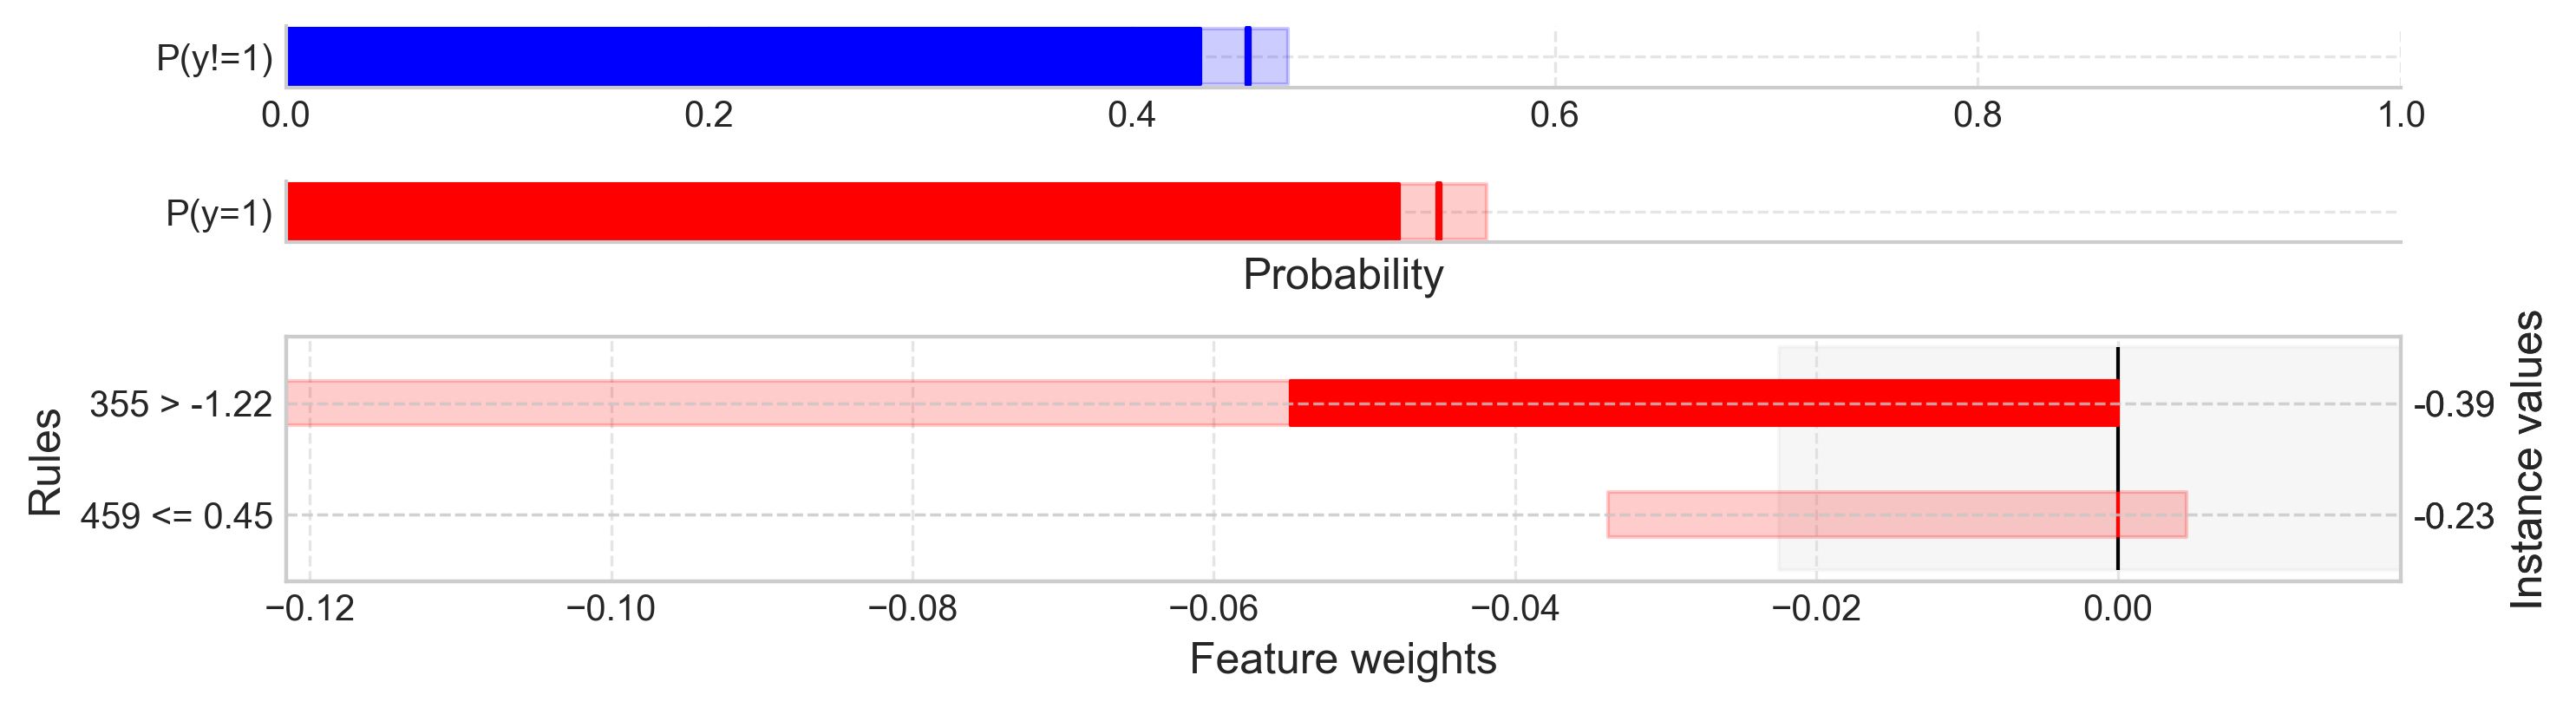

Prediction [ Low ,  High]
0.714 [0.700, 0.750]
Value : Feature                                  Weight [ Low  ,  High ]

Prediction [ Low ,  High]
0.824 [0.786, 1.000]
Value : Feature                                  Weight [ Low  ,  High ]

Prediction [ Low ,  High]
0.300 [0.263, 0.316]
Value : Feature                                  Weight [ Low  ,  High ]
-0.86 : 329 > -1.11                              -0.245 [-0.268, -0.226]



C:\Users\loftuw\CUDATemp\ipykernel_16720\3616243613.py:3: UserWarning: The explanation has no rules to plot. The index of the instance is 1
  e.plot(uncertainty=True)
C:\Users\loftuw\CUDATemp\ipykernel_16720\3616243613.py:3: UserWarning: The explanation has no rules to plot. The index of the instance is 2
  e.plot(uncertainty=True)


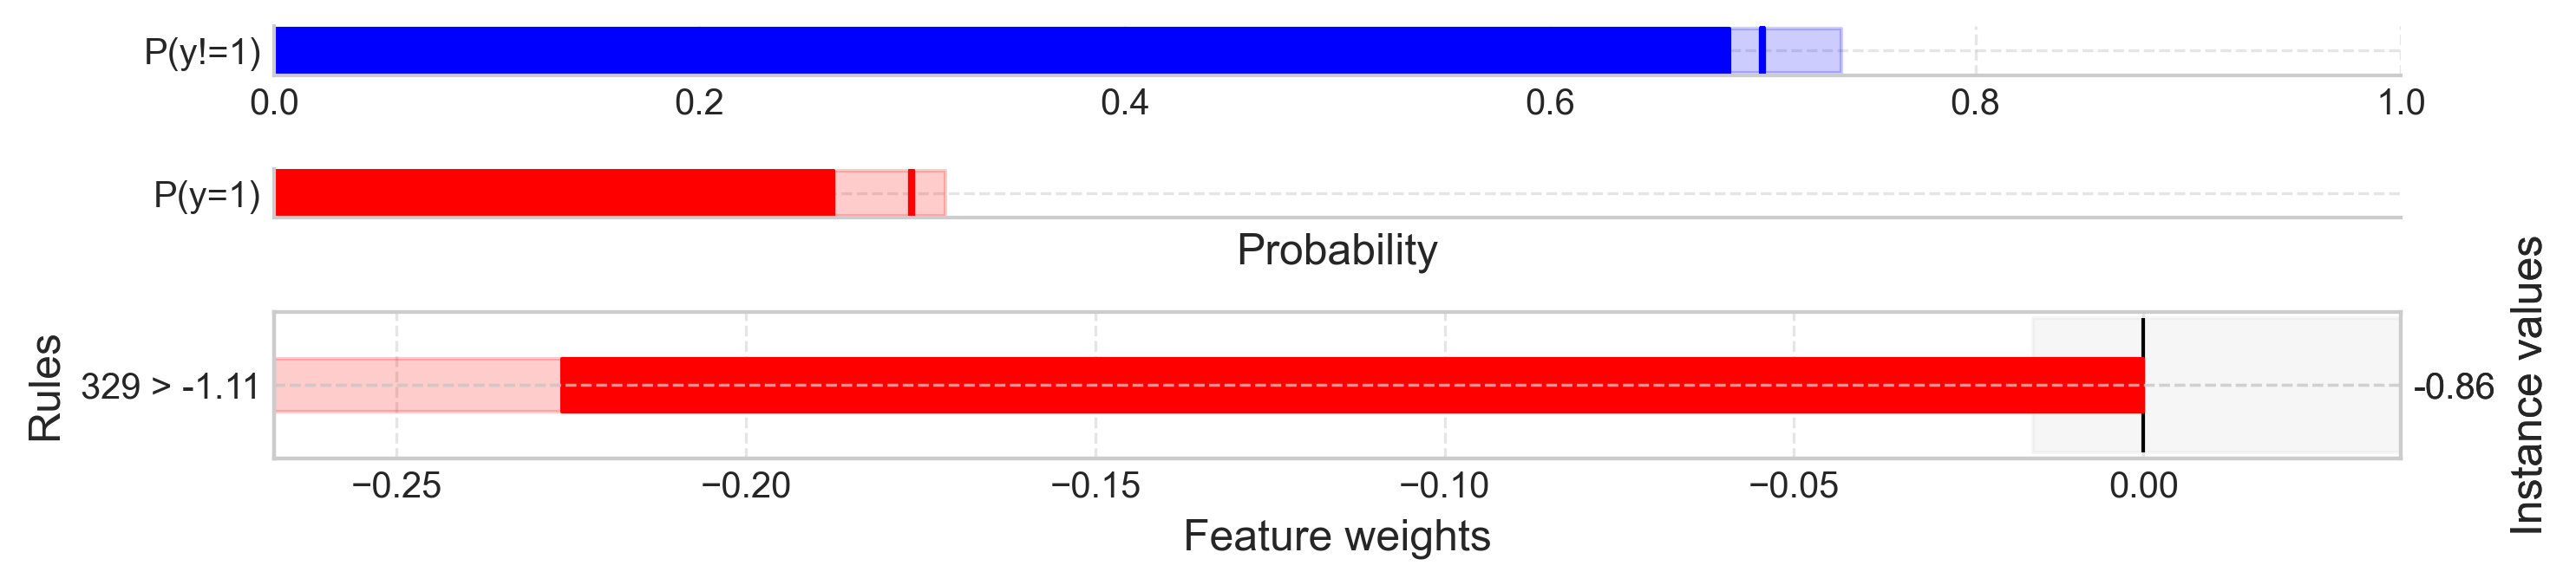

Prediction [ Low ,  High]
0.545 [0.526, 0.568]
Value : Feature                                  Weight [ Low  ,  High ]
1.21  : 329 > -1.11                              -0.080 [-0.122, -0.055]



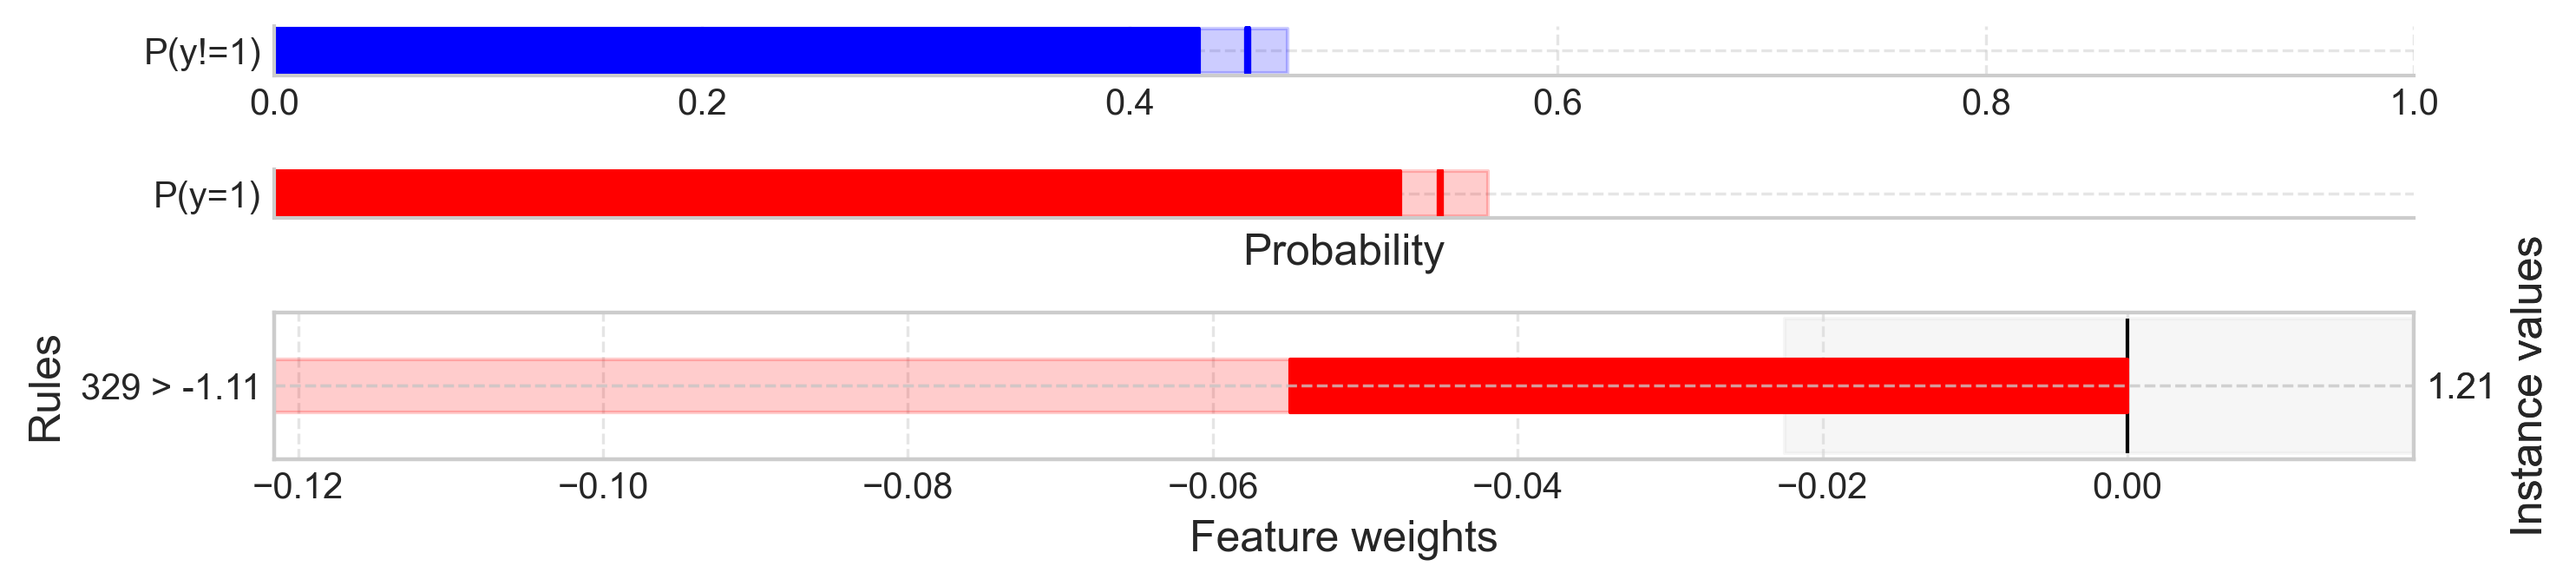

In [13]:
for e in explanations[:5]:
    print(e)
    e.plot(uncertainty=True)

In [14]:
# Inspect how many features remain after filtering
num_features = explainer.num_features
ignored = set(explanations.features_to_ignore)
kept = [f for f in range(num_features) if f not in ignored]
num_features, len(kept), kept

(2000, 5, [11, 329, 355, 459, 1961])

The length of `kept` should be less than or equal to `per_instance_top_k` passed to `perf_feature_filter`.

You can tweak `per_instance_top_k` and rerun the notebook to see how the effective feature budget changes.

In [15]:
# Construct the wrapper from the config
wrapper_all = WrapCalibratedExplainer(learner)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper_all.calibrate(X_cal, y_cal)
explainer = wrapper_all.explainer

In [16]:
explanations_all = wrapper_all.explain_factual(X_test)
explanations_all.features_to_ignore

array([], dtype=int32)